<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl/blob/main/Proyecto_DFO_ruido_problemas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [94]:
def L_BFGS(S,Y,g):#Checar las posibles divisiones por cero
    n=len(g)
    m=len(S)
    #supondremos H_0 un multiplo de la identidad
    H_0=(np.dot(S[-1],Y[-1])/(np.max([np.dot(Y[-1],Y[-1]),10**(-6)] )))*np.identity(n)#Dado en clase.
    q=g
    alphas=[]
    for i in range(m):
        alphas.append((1/max(10**(-6),np.dot(S[m-1-i],Y[m-1-i])))*np.dot(S[m-1-i],q))
        q=q-alphas[i]*Y[m-1-i]
    r=np.dot(H_0,q)
    for i in range(m):
        beta=(1/max(10**(-6),np.dot(Y[i],S[i])))*np.dot(Y[i],r)
        r=r+S[i]*(alphas[m-1-i]-beta)#aproximacion de -H*g
    return r
def ECNoise(F):#F es un vector que guarda f(t_i), i=0,...,m. Evaluaciones de m+1 puntos equiespaciados
#Ver metodo en Estimating_Computational_Noise, pagina 8
    m=len(F)-1
    T=np.zeros((m+1,m+1))
    for i in range(m+1):
        T[i,0]=F[i]
    for k in range(m):
        for i in range(m-k):
            T[i,k+1]=T[i+1,k]-T[i,k]
    return T
def var_estimation(T):#Recibe la tabla.
    m=len(T)-1
    sigma_array=[]
    for k in range(1,m):
        sigma_array.append(((np.math.factorial(k)/np.math.factorial(2*k))/(m+1-k))*np.sum(T.T[k]**2))
    #Ahora checamos las 2 condiciones.
    for k in range(1,m-2):
        max_k=np.max(sigma_array[k:k+2])
        min_k=np.min(sigma_array[k:k+2])
        if(max_k<=4*min_k):
            if(np.sign(min_k*max_k)==-1):
                print("es el ", k)
                break
    return np.sqrt(sigma_array[k])#Podria ser que las condiciones no se cumplan, en tal caso regresa la ultima estimacion sigma.
def aprox_f_biprima(e_f,f,x_k,p):#Usando una direccion (aleatoria dada) se aproxima el max ||Hessiana_f(x_k)*p||
    #Ver Estimating Derivatives of Noisy Simulations, pagina 14.
    tao_1=100
    tao_2=0.1
    h_a=e_f**(1/4)
    f_mas=f(x_k+h_a*p)
    f_menos=f(x_k-h_a*p)
    f_0=f(x_k)
    delta_h_a=abs(f_mas+f_menos-2*f_0)
    mu_a=delta_h_a/(np.max([h_a**2,10**(-6)]))
    if(delta_h_a/np.max([e_f,10**(-6)])>=tao_1):
        mu=mu_a
        if(abs(f_mas-f_0)<=tao_2*max(f_mas,f_menos,f_0) and abs(f_menos-f_0)<=tao_2*max(f_mas,f_menos,f_0)):
            return mu_a
    h_b=(e_f/np.max([mu_a,10**(-6)]))**(1/4)
    f_mas=f(x_k+h_b*p)
    f_menos=f(x_k-h_b*p)
    delta_h_b=abs(f_mas+f_menos-2*f_0)
    mu_b=delta_h_b/(np.max([h_b**2,10**(-6)] ))
    if(delta_h_b/np.max([e_f,10**(-6)])>=tao_1):
        mu=mu_b
        if(abs(f_mas-f_0)<=tao_2*max(f_mas,f_menos,f_0) and abs(f_menos-f_0)<=tao_2*max(f_mas,f_menos,f_0)):
            return mu_b
    if(abs(mu_a-mu_b)<=0.5*mu_b):
        return mu_b
    #print("No hay regla de decision")
    return np.max([mu_a,mu_b,10**(-6)])#Por falta de relga de descicion. En el algoritmo no se especifica una opcion.

def rutina_h(f,p,x_0,m=10):#Calcula h a partir de una direccion dada, con m+1 puntos equiespaciados.
    f_0=f(x_0)
    n=len(x_0)
    delta=10**(-3)#Suggested by ECnoise algorithm.
    F_st=[f(x_0+delta*i*p) for i in range(m)]
    T=ECNoise(F_st)
    e_f=var_estimation(T)
    #print("e_f: ",e_f)#Breakpoint
    mu=aprox_f_biprima(e_f=e_f,f=f,x_k=x_0,p=p)
    h=(8**(1/4))*(e_f/np.max([mu,10**(-6)]))**(1/2)
    return e_f,h
def relaxed_Armijo(x_k,f,fprime,d,alpha_0=1,e_f=0.0,c_1=0.1,c_2=0.9,
                   max_iter=10**2):##Intenté usar scipy.line_search(), pero Strong Wolfe son dificiles de satisfacerse
    #Metodo visto en clase.
    iter=0
    alpha=0
    grad_f_k=fprime(x_k)
    f_k=f(x_k)
    beta=np.inf
    alpha_i=alpha_0
    g_dot_d=np.dot(grad_f_k,d)
    Armijo=False
    for i in range(max_iter):
        if(f(x_k+alpha_i*d)>f_k+c_1*alpha_i*g_dot_d+2*e_f):#Aqui esta la condicion relajada, dado e_f estimacion del error estandar.
            beta=alpha_i
            alpha_i=0.5*(alpha+beta)
        else:
            Armijo=True
            if(np.dot(fprime(x_k+alpha_i*d),d)<c_2*g_dot_d):
                alpha=alpha_i
                if(beta==np.inf):
                    alpha_i=2*alpha
                else:
                    alpha_i=0.5*(alpha+beta)
            else:
                break
    if(Armijo==True):
        return alpha_i
    else:
        return Armijo

In [95]:
def recovery(x_k,f,grad_k,e_f,h,l1,l2,d_k,m=10):#Genera un nuevo h
    d_k=d_k/np.max(d_k)
    e_f_b,h_b=rutina_h(f=f,p=d_k,m=m,x_0=x_k)
    n=len(x_k)
    f_stencil=[]
    f_k=f(x_k)
    if(h_b<l1*h or h_b>l2*h):
        return x_k,e_f_b,h_b
    else:
        
        x_h=x_k+h*(d_k)
        f_h=f(x_h)
        if(f_h<=f(x_k)+0.1*h*np.dot(grad_k,d_k)+2*e_f):
            return x_h,e_f,h
        else:
            for i in range(n):
                x_s=x_k
                x_s[i]+=h
                f_stencil.append(f(x_s))
            ii=np.argmin(f_stencil)
            x_s=x_k
            x_s[ii]+=h
            f_s=f(x_s)
            if(f_h<=f_s and f_h<=f_k):
                return x_h,e_f,h
            else:
                if(f_k>f_s and f_h>f_s):
                    return x_s,e_f,h
                else:
                    e_f_n,h_n=rutina_h(f=f,p=np.random.uniform(-1,1,size=n),m=m,x_0=x_k)
                    return x_k,e_f_n,h_n

In [115]:
import copy
def CD_grad(x, fun, h=None, ret_sten=False):
    if h is None:
        h = np.max([1.0]+[np.abs(v) for v in x])*(1e-6)
    
    h = np.max([1e-6, h])
    
    f_p = np.zeros(x.shape[0])
    f_n = np.zeros(x.shape[0])
    
    for i in range(x.shape[0]):
        dum_x = copy.deepcopy(x)
        dum_x[i] += h
        f_p[i]    = fun(dum_x)
        dum_x[i] -= 2*h
        f_n[i]    = fun(dum_x)
    
    g = ( f_p - f_n )/(2*h)
    
    if ret_sten:
        min_p = np.argmin(f_p)
        min_n = np.argmin(f_n)
        s_id = min_n           #assume that min value is for min_n index
        x_s  = x[s_id] - h
        f_s  = f_n[s_id]
        if f_p[min_p] < f_n[min_n]:
            x_s = x[min_p] + h
            f_s = f_p[min_p]
        
        return g, [x_s, f_s]
        
    else:
        return g

In [153]:
def Rosembrok_grad(X):
    n=len(X)
    grad=np.zeros(n)
    grad[1:-1]=-400*X[1:-1]*(X[2:]-X[1:-1]**2)+200*(X[1:-1]-X[:-2]**2)-2*(1-X[1:-1])
    grad[0]=-400*X[0]*(X[1]-X[0]**2)-2*(1-X[0])
    grad[-1]=200*(X[-1]-X[-2]**2)
    return grad

In [179]:
import time
def find_minimum(f,x_0,tol_g=10**(-4),zeta=0.01,max_iter=10**2,alpha_max_iter=100,m=10,ml=200,f_opt=0,derivative_dif='FD',stop_crit='grad',h_bound=10**(-6),plot=False):
    t1 = time.time()
    n=len(x_0)
    #----------------------
    #Listas
    iter=0
    GG=[]
    Y=[]
    S=[]
    FF=[abs(f(x_0)-f_opt)]
    #----------------------
    #Primera iteracion para crear S_k, Y_k------------------------
    e_f,h=rutina_h(f=f,p=np.random.uniform(-1,1,size=len(x_0)),m=m,x_0=x_0)
    def fprime(x):
        if(derivative_dif=='FD'):
            return CD_grad(x, fun=f, h=np.max([h,h_bound]), ret_sten=False)
        else:
            if(derivative_dif=='CD'):
                return scipy.optimize.approx_fprime(xk=x,f=f,epsilon=np.max([h,h_bound]))
    g_0=fprime(x_0)#Gradiente
    alpha_k=relaxed_Armijo(f=f,fprime=fprime,x_k=x_0,d=-g_0,e_f=e_f,max_iter=alpha_max_iter)#line_search
    x_1=x_0-alpha_k*g_0#Primera direccion de descenso es -grad(x_0)
    g_1=fprime(x_1)
    GG.append(np.linalg.norm(g_1))
    #---------------------- 
    Y.append(g_1-g_0)#diferencia de gradientes
    S.append(-alpha_k*g_0)#diferencia de x's
    FF.append(abs(f(x_1)-f_opt))#Meta-Convergencia
    #----------------------
    nonstop_criteria=True
    while(nonstop_criteria and iter<max_iter):#Criterio de paro
        x_0=x_1
        g_0=g_1
        d_k=-L_BFGS(S=S,Y=Y,g=g_1)
        if(iter>ml and len(Y)>ml-10):#Elimina los viejos s_k,y_k
            del S[0]
            del Y[0]
        alpha_k_try=relaxed_Armijo(f=f,fprime=fprime,x_k=x_0,d=d_k,e_f=e_f,max_iter=alpha_max_iter)
        if(alpha_k_try==False):
            x_1,e_f,h=recovery(x_k=x_0,f=f,grad_k=g_1,e_f=e_f,h=h,l1=0.01,l2=100,d_k=d_k,m=12)
            def fprime(x):
                if(derivative_dif=='FD'):
                    return CD_grad(x, fun=f, h=np.max([h,h_bound]), ret_sten=False)
                else:
                    if(derivative_dif=='CD'):
                        return scipy.optimize.approx_fprime(xk=x,f=f,epsilon=np.max([h,h_bound]))
        else:
            x_1=x_0+alpha_k*d_k#Actualizacion
        g_1=fprime(x_1)
        if(stop_crit=='grad'):
            nonstop_criteria=np.linalg.norm(g_1)>tol_g
        else:
            nonstop_criteria=abs((f(x_1)-f(x_0))/np.max([1,f(x_0)]))>tol_g
        iter+=1
        #H_k=H_k_m
        y_k=g_1-g_0
        s_k=x_1-x_0
        if(np.dot(s_k,y_k)>=zeta*np.linalg.norm(y_k)*np.linalg.norm(s_k)):
            Y.append(y_k)
            S.append(s_k)
        GG.append(np.linalg.norm(g_1))
        FF.append(abs(f(x_1)-f_opt))
    if(plot):
        plt.plot(FF)
        plt.title(r'k vs. $|f(x_k)-f(x^*)|$')
        plt.show()
    print("Summary: ")    
    t2 = time.time()
    tim = t2-t1
    niter = iter
    print("time: {:.02e}\t Niter: {} \t ||g_k||: {:.02e} ".format(
             tim,niter,GG[-1]))
    return x_1

In [165]:
def find_minimum_Rosembrok(x_0,f,grad_f=Rosembrok_grad,tol=10**(-3),zeta=0.01,max_iter=10**3,f_opt=0,stop_crit='grad',plot=False):
    t1 = time.time()
    n=len(x_0)
    iter=0
    alpha_max_iter=100
    GG=[]
    Y=[]
    S=[]
    FF=[abs(f(x_0)-f_opt)]
    g_0=grad_f(x_0)#Gradiente
    alpha_k=relaxed_Armijo(f=f,fprime=grad_f,x_k=x_0,d=-g_0,e_f=0,max_iter=alpha_max_iter)#line_search
    x_1=x_0-alpha_k*g_0#Primera direccion de descenso es -grad(x_0)
    g_1=grad_f(x_1)
    GG.append(np.linalg.norm(g_1))
    #---------------------- 
    Y.append(g_1-g_0)#diferencia de gradientes
    S.append(-alpha_k*g_0)#diferencia de x's
    FF.append(abs(f(x_1)-f_opt))#Meta-Convergencia
    #----------------------
    nonstop_criteria=True
    while(nonstop_criteria and iter<max_iter):#Criterio de paro
        x_0=x_1
        g_0=g_1
        d_k=-L_BFGS(S=S,Y=Y,g=g_1)
        if(iter>100 and len(Y)>100-10):#Elimina los viejos s_k,y_k
            del S[0]
            del Y[0]
        alpha_k_try=relaxed_Armijo(f=f,fprime=grad_f,x_k=x_0,d=d_k,e_f=0,max_iter=alpha_max_iter)
        if(alpha_k_try!=False):
            alpha_k=alpha_k_try
        
        x_1=x_0+alpha_k*d_k#Actualizacion
        g_1=grad_f(x_1)
        if(stop_crit=='grad'):
            nonstop_criteria=np.linalg.norm(g_1)>tol
        else:
            nonstop_criteria=abs((f(x_1)-f(x_0))/np.max([1,f(x_0)]))>tol
        iter+=1
        #H_k=H_k_m
        y_k=g_1-g_0
        s_k=x_1-x_0
        if(np.dot(s_k,y_k)>=zeta*np.linalg.norm(y_k)*np.linalg.norm(s_k)):
            Y.append(y_k)
            S.append(s_k)
        GG.append(np.linalg.norm(g_1))
        FF.append(abs(f(x_1)-f_opt))
    print("Summary: ")
    if(plot):
        plt.plot(GG)
        #plt.title(r'k vs. $|f(x_k)-f(x^*)|$')
        plt.title(r'k vs. $||\nabla f(x_k)||$')
        plt.show()
    t2 = time.time()
    tim = t2-t1
    niter = iter
    print("time: {:.02e}\t Niter: {} \t ||g_k||: {:.02e} ".format(
             tim,niter,GG[-1]))
    return x_1

In [ ]:
#Muestra de que una buena aproximacion del gradiente es suficiente para un buen comportamiento.
plot=False
for n in [5,10,20,50,100,200,500]:
    if(n==500):
        plot=True
    print("\n------------------------")
    print("Rosembrok dimension ", n)
    for eps in [10**(-1),10**(-2),10**(-4)]:
        print("\nRuido Aditivo",r'$\sim U($',-eps,",",eps,")")
        def Rosembrok_ruido(X):#X es un vector.
            return (np.sum(100*(X[1:]-X[:-1]**2)**2+(1-X[:-1])**2)+eps*np.random.uniform(0,1))#Ruido
    
        x_0=np.random.uniform(0,2,size=n)
        x_opt=find_minimum_Rosembrok(x_0,f=Rosembrok_ruido,grad_f=Rosembrok_grad,tol=10**(-3),zeta=0.01,max_iter=5*10**3,f_opt=0,stop_crit='grad',plot=plot)

In [97]:
def p_204(X):#x_0=np.array([0.1,0.1] ), x_opt=np.array([0,0] )
    A=np.array([0.13294 ,-0.244378, 0.325895] )
    D=np.array([2.5074 ,-1.36401,1.02282] )
    H=np.array([[-0.564255 ,0.392417], [ -0.404979, 0.927589], [-0.0735084 ,0.535493]] )
    B=np.linalg.inv(np.dot(H.T,H))
    W=A+np.dot(H,X)+0.5*np.dot(X,np.dot(B,X))*D
    return np.dot(W,W)+np.random.uniform(-10**(-2),10**(-2))

In [98]:
def p_205(X):#x_0=np.array([0.1,0.] ), x_opt=np.array([3,0.5] )
    return ((1.5-X[0]*(1-X[1]))**2+(2.25-X[0]*(1-X[1]**2))**2+(2.625-X[0]*(1-X[1]**3))**2)


In [99]:
def p_206(X):#x_0=[-1.2,1], x_opt=[1,1]
    return ((X[1]-X[0]**2)**2+100*(1-X[0])**2)

In [100]:
def p_212(X):#x_0=[2,0], x_opt=[0,0]
    return (((4*(X[0]+X[1]))**2+(4*(X[0]+X[1])+(X[0]-X[1])*((X[0]-2)**2+X[1]**2-1))**2))


In [101]:
def p_214(X):#x_0=[-1.2,1], x_opt=[1,1]
    return ((10*(X[0]-X[1])**2+(X[0]-1)**2)**(1/4))

In [102]:
def p_271(X):#x_0=np.array([0,0,0,0,0,0]),x_opt=np.array([1,1,1,1,1,1])
    suma=0
    for i in range(1,len(X)+1):
        suma+=(16-i)*(X[i-1]-1)**2
    return 10*suma

In [103]:
def p_276(X):#x_0=np.array([-4,-2,-1.333,-1,-0.8,-0.6667]), x_opt=np.zeros(6)
    n=len(X)
    X=np.array(X)
    A=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if(i+j!=1):
                A[i,j]=1/(i+j+1)
    return np.dot(X,np.dot(A,X))

In [104]:
def p_281(X):#x_0=np.array([0,0,0,0,0,0,0,0,0,0]), x_opt=np.ones(10)
    suma=0
    for i in range(1,len(X)+1):
        suma+=(i**3)*(X[i-1]-1)**2
    return suma**(1/3)

In [105]:
def p_282(X):#x_0=[-1.2,0,0,0,0,0,0,0,0,0], x_opt=np.ones(10)
    sum=0
    for i in range(1,len(X)):
        sum+=(10-i)*(X[i-1]**2-X[i])**2
    return (X[0]-1)**2+(X[9]-1)**2+10*sum

In [106]:
def p_283(X):#x_0=np.zeros(10), x_opt=np.ones(10)
    sum=0
    for i in range(1,len(X)+1):
        sum+=(i**3)*(X[i-1]-1)**2
    return sum**3


In [107]:
def p_303(X):#x_0=np.ones(20)*0.1, x_opt=np.zeros(20)
    sum_1=0
    sum_2=0
    sum_3=0
    for i in range(1,len(X)+1):
        sum_1+=X[i-1]**2
        sum_2+=0.5*i*X[i-1]
    return sum_1+sum_2**2+sum_2**4

In [108]:
def p_ros(X):
    return (np.sum(100*(X[1:]-X[:-1]**2)**2+(1-X[:-1])**2))

In [109]:
def additive_noise(f,x,eps=10**(-2),label='stochastic'):
    if(label=='stochastic'):
        u=np.random.uniform(-eps,eps)
    return(f(x)+u)
def multiplicative_noise(f,x,eps=10**(-2),label='stochastic'):
    if(label=='stochastic'):
        u=np.random.uniform(-eps,eps)
    return(f(x)*(1+u))

In [110]:
def f_noise(f,x,eps,noise):
        if(noise=='additive'):
            return additive_noise(f=f,eps=eps,x=x)
        if(noise=='multiplicative'):
            return multiplicative_noise(f=f,eps=eps,x=x)

In [177]:
#Funciones de prueba con ruido.
funciones=[p_204,p_205,p_206,p_212,p_271,p_276,p_281,p_282,p_283,p_303,p_ros]
x_initial=[np.array([0.1,0.1] ),np.array([0.1,0.] ),[-1.2,1],[2,0],np.array([0,0,0,0,0,0]),np.array([-4,-2,-1.333,-1,-0.8,-0.6667]),np.array([0,0,0,0,0,0,0,0,0,0]),[-1.2,0,0,0,0,0,0,0,0,0],np.zeros(10), np.ones(20)*0.1, np.zeros(50) ]
x_optims=np.array([[0,0],[3,0.5],[1,1],[0,0] ,np.array([1,1,1,1,1,1]),np.zeros(6),np.ones(10),np.ones(10),np.ones(10),np.zeros(20),np.ones(50)])
noise_type=['additive','multiplicative']
for i in range(len(funciones)):
    f=funciones[i]
    print("Function: ", str(f))
    x_0=x_initial[i]
    n=len(x_0)
    for noise in noise_type:
        print(noise+' Case\n')
        def f_1(x):
            return f_noise(f=f,eps=10**(-3),x=x,noise=noise)
        x_opt=find_minimum(f=f_1,x_0=np.array(x_0),tol_g=10**(-6),max_iter=3*10**3,alpha_max_iter=10,m=8,ml=200,f_opt=f(x_optims[i]),derivative_dif='CD',stop_crit='otro',h_bound=10**(-3))
        print("||x_opt-x^*||:",np.linalg.norm(x_opt-x_optims[i]))
        print("|f(x_opt)-f(x^*)|:",abs(f(x_opt)-f(x_optims[i])))
        print("--------------------------")
    print("---------------------------------")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


Function:  <function p_204 at 0x7f058ee85cb0>
additive Case

Summary: 
time: 7.43e+00	 Niter: 1339 	 ||g_k||: 9.74e+00 
||x_opt-x^*||: 0.17002405303358256
|f(x_opt)-f(x^*)|: 0.23719916986416684
--------------------------
multiplicative Case

Summary: 
time: 1.70e+01	 Niter: 3000 	 ||g_k||: 1.43e+01 
||x_opt-x^*||: 0.1653425414080998
|f(x_opt)-f(x^*)|: 0.24192034656457803
--------------------------
---------------------------------
Function:  <function p_205 at 0x7f058ee855f0>
additive Case

Summary: 
time: 4.13e-01	 Niter: 235 	 ||g_k||: 1.32e+00 
||x_opt-x^*||: 0.41729670360201254
|f(x_opt)-f(x^*)|: 0.04251911081587665
--------------------------
multiplicative Case

Summary: 
time: 1.06e-01	 Niter: 122 	 ||g_k||: 1.21e-03 
||x_opt-x^*||: 0.7835392763486254
|f(x_opt)-f(x^*)|: 0.24162446598161644
--------------------------
---------------------------------
Function:  <function p_206 at 0x7f058e4ad5f0>
additive Case

Summary: 
time: 3.56e+00	 Niter: 1475 	 ||g_k||: 1.33e+00 
||x_opt-x^*|

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Summary: 
time: 4.12e+00	 Niter: 1289 	 ||g_k||: 9.70e+10 
||x_opt-x^*||: 3.0663531079332795
|f(x_opt)-f(x^*)|: 22306320750.708065
--------------------------
---------------------------------
Function:  <function p_303 at 0x7f058eae3170>
additive Case

Summary: 
time: 7.98e-03	 Niter: 1 	 ||g_k||: 1.25e+05 
||x_opt-x^*||: 0.44721359549995804
|f(x_opt)-f(x^*)|: 12265.5125
--------------------------
multiplicative Case

Summary: 
time: 2.71e+00	 Niter: 656 	 ||g_k||: 4.67e+05 
||x_opt-x^*||: 0.6780316534582724
|f(x_opt)-f(x^*)|: 60761.976959102634
--------------------------
---------------------------------
Function:  <function p_ros at 0x7f058eae3440>
additive Case

Summary: 
time: 1.18e-01	 Niter: 16 	 ||g_k||: 1.28e+01 
||x_opt-x^*||: 7.022654727019843
|f(x_opt)-f(x^*)|: 48.64894180258995
--------------------------
multiplicative Case

Summary: 
time: 6.95e+00	 Niter: 1103 	 ||g_k||: 1.94e+02 
||x_opt-x^*||: 6.968165416166534
|f(x_opt)-f(x^*)|: 48.59340501071649
----------------------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


Function:  <function p_204 at 0x7f058ee85cb0>
additive Case



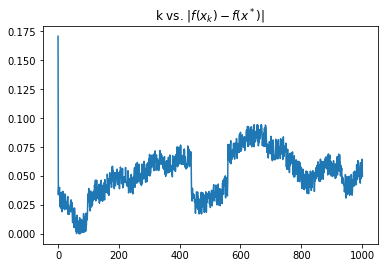

Summary: 
time: 5.95e+00	 Niter: 1000 	 ||g_k||: 1.55e+00 
||x_opt-x^*||: 0.08881167228653096
|f(x_opt)-f(x^*)|: 0.049168207589693286
--------------------------
multiplicative Case



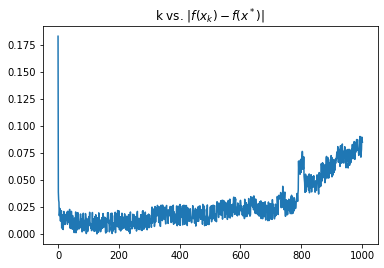

Summary: 
time: 5.80e+00	 Niter: 1000 	 ||g_k||: 2.76e+01 
||x_opt-x^*||: 0.09560748749210254
|f(x_opt)-f(x^*)|: 0.07213893428354642
--------------------------
---------------------------------
Function:  <function p_205 at 0x7f058ee855f0>
additive Case



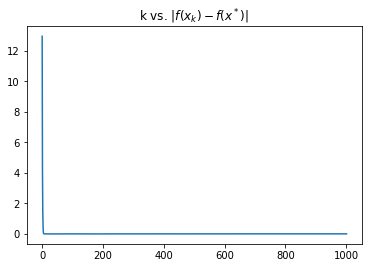

Summary: 
time: 2.78e+00	 Niter: 1000 	 ||g_k||: 3.87e+00 
||x_opt-x^*||: 0.1440075585112411
|f(x_opt)-f(x^*)|: 0.003540692878148125
--------------------------
multiplicative Case



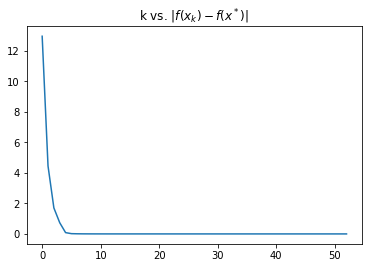

Summary: 
time: 1.85e-01	 Niter: 51 	 ||g_k||: 7.91e-04 
||x_opt-x^*||: 0.004011978092506652
|f(x_opt)-f(x^*)|: 2.6032296484528644e-06
--------------------------
---------------------------------
Function:  <function p_206 at 0x7f058e4ad5f0>
additive Case



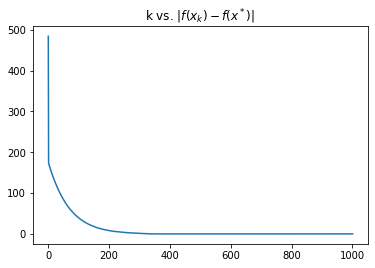

Summary: 
time: 2.57e+00	 Niter: 1000 	 ||g_k||: 1.02e+01 
||x_opt-x^*||: 0.2008031941872231
|f(x_opt)-f(x^*)|: 0.2473008463341995
--------------------------
multiplicative Case



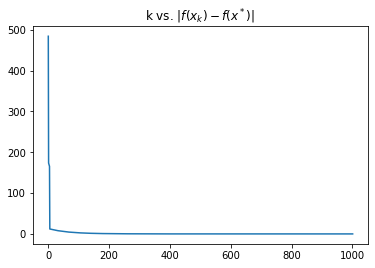

Summary: 
time: 2.49e+00	 Niter: 1000 	 ||g_k||: 3.76e-01 
||x_opt-x^*||: 0.014610425398071818
|f(x_opt)-f(x^*)|: 0.0005015649036355957
--------------------------
---------------------------------
Function:  <function p_212 at 0x7f058eadf680>
additive Case



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


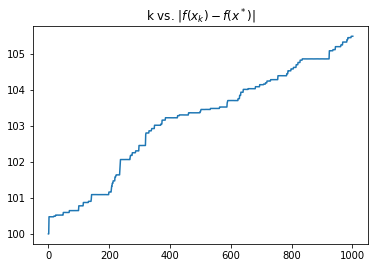

Summary: 
time: 2.68e+00	 Niter: 1000 	 ||g_k||: 1.68e+02 
||x_opt-x^*||: 2.0332655799939623
|f(x_opt)-f(x^*)|: 105.48542094096206
--------------------------
multiplicative Case



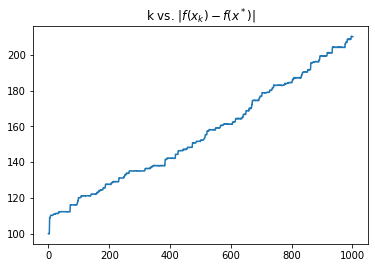

Summary: 
time: 2.70e+00	 Niter: 1000 	 ||g_k||: 2.95e+02 
||x_opt-x^*||: 2.511135212724425
|f(x_opt)-f(x^*)|: 210.12870104776852
--------------------------
---------------------------------
Function:  <function p_271 at 0x7f058eae6200>
additive Case



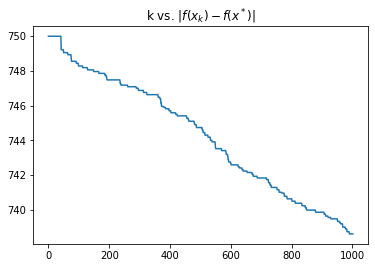

Summary: 
time: 3.09e+00	 Niter: 1000 	 ||g_k||: 6.10e+02 
||x_opt-x^*||: 2.430288214638343
|f(x_opt)-f(x^*)|: 738.6203043306859
--------------------------
multiplicative Case



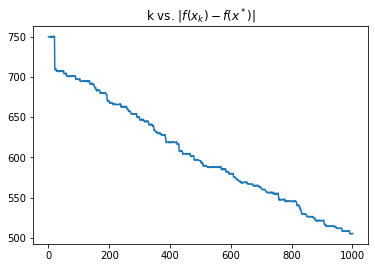

Summary: 
time: 3.16e+00	 Niter: 1000 	 ||g_k||: 5.32e+02 
||x_opt-x^*||: 1.9996288824671484
|f(x_opt)-f(x^*)|: 505.36664159056295
--------------------------
---------------------------------
Function:  <function p_276 at 0x7f058eae6320>
additive Case



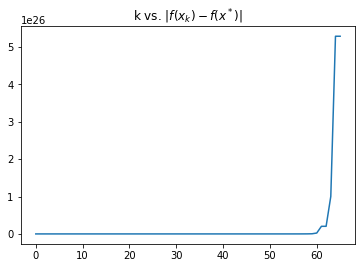

Summary: 
time: 3.85e-01	 Niter: 64 	 ||g_k||: 0.00e+00 
||x_opt-x^*||: 484175360354326.94
|f(x_opt)-f(x^*)|: 5.2866749517134456e+26
--------------------------
multiplicative Case



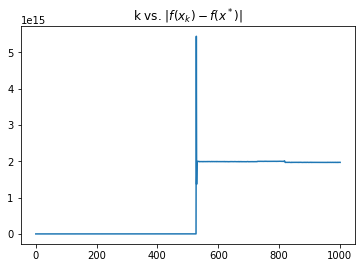

Summary: 
time: 3.74e+00	 Niter: 1000 	 ||g_k||: 2.13e+11 
||x_opt-x^*||: 59387468.87420211
|f(x_opt)-f(x^*)|: 1971154476994296.0
--------------------------
---------------------------------
Function:  <function p_281 at 0x7f058eae67a0>
additive Case



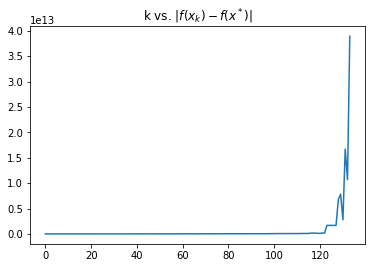

Summary: 
time: 5.32e-01	 Niter: 132 	 ||g_k||: 0.00e+00 
||x_opt-x^*||: 1.482307832408939e+19
|f(x_opt)-f(x^*)|: 38934575091631.64
--------------------------
multiplicative Case



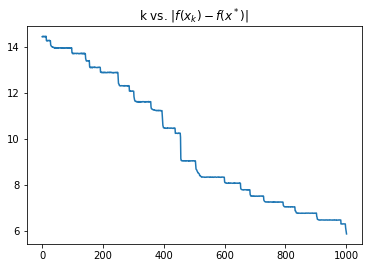

Summary: 
time: 5.18e+00	 Niter: 1000 	 ||g_k||: 3.22e+00 
||x_opt-x^*||: 2.041676783373611
|f(x_opt)-f(x^*)|: 5.870969894118542
--------------------------
---------------------------------
Function:  <function p_282 at 0x7f058eae6c20>
additive Case



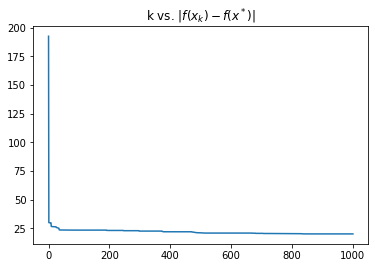

Summary: 
time: 6.47e+00	 Niter: 1000 	 ||g_k||: 1.01e+02 
||x_opt-x^*||: 3.0292640708220837
|f(x_opt)-f(x^*)|: 20.246288580821343
--------------------------
multiplicative Case



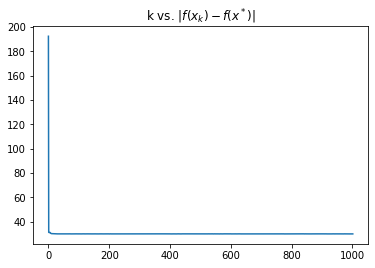

Summary: 
time: 6.62e+00	 Niter: 1000 	 ||g_k||: 1.40e+02 
||x_opt-x^*||: 2.987910251922852
|f(x_opt)-f(x^*)|: 29.991517389515195
--------------------------
---------------------------------
Function:  <function p_283 at 0x7f058eae3050>
additive Case



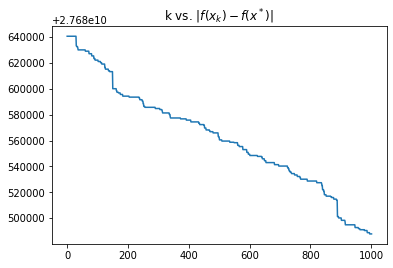

Summary: 
time: 3.80e+00	 Niter: 1000 	 ||g_k||: 7.72e+10 
||x_opt-x^*||: 3.1622752558938316
|f(x_opt)-f(x^*)|: 27680487883.076443
--------------------------
multiplicative Case



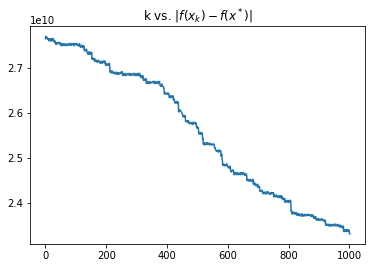

Summary: 
time: 3.77e+00	 Niter: 1000 	 ||g_k||: 1.26e+11 
||x_opt-x^*||: 3.0864581405362594
|f(x_opt)-f(x^*)|: 23327763466.06246
--------------------------
---------------------------------
Function:  <function p_303 at 0x7f058eae3170>
additive Case



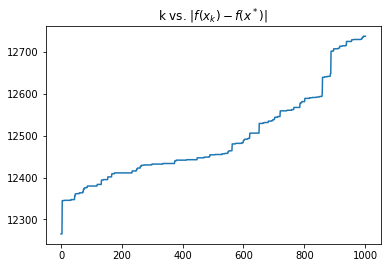

Summary: 
time: 5.66e+00	 Niter: 1000 	 ||g_k||: 1.28e+05 
||x_opt-x^*||: 0.4516715155791588
|f(x_opt)-f(x^*)|: 12737.982091198804
--------------------------
multiplicative Case



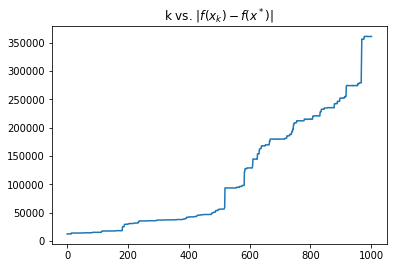

Summary: 
time: 5.79e+00	 Niter: 1000 	 ||g_k||: 2.50e+06 
||x_opt-x^*||: 1.073541063961238
|f(x_opt)-f(x^*)|: 361257.0233295185
--------------------------
---------------------------------
Function:  <function p_ros at 0x7f058eae3440>
additive Case



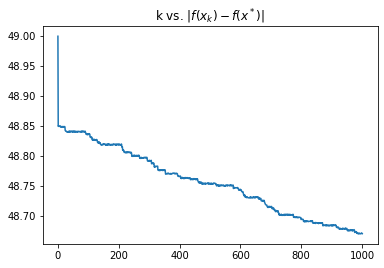

Summary: 
time: 1.41e+01	 Niter: 1000 	 ||g_k||: 2.04e+01 
||x_opt-x^*||: 7.015227741719376
|f(x_opt)-f(x^*)|: 48.670495889397436
--------------------------
multiplicative Case



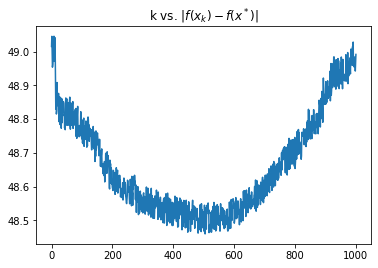

Summary: 
time: 9.66e+00	 Niter: 1000 	 ||g_k||: 7.05e+02 
||x_opt-x^*||: 6.926152808860788
|f(x_opt)-f(x^*)|: 48.98590501699393
--------------------------
---------------------------------


In [182]:
#Funciones de prueba con ruido.
funciones=[p_204,p_205,p_206,p_212,p_271,p_276,p_281,p_282,p_283,p_303,p_ros]
x_initial=[np.array([0.1,0.1] ),np.array([0.1,0.] ),[-1.2,1],[2,0],np.array([0,0,0,0,0,0]),np.array([-4,-2,-1.333,-1,-0.8,-0.6667]),np.array([0,0,0,0,0,0,0,0,0,0]),[-1.2,0,0,0,0,0,0,0,0,0],np.zeros(10), np.ones(20)*0.1, np.zeros(50) ]
x_optims=np.array([[0,0],[3,0.5],[1,1],[0,0] ,np.array([1,1,1,1,1,1]),np.zeros(6),np.ones(10),np.ones(10),np.ones(10),np.zeros(20),np.ones(50)])
noise_type=['additive','multiplicative']
for i in range(len(funciones)):
    f=funciones[i]
    print("Function: ", str(f))
    x_0=x_initial[i]
    n=len(x_0)
    for noise in noise_type:
        print(noise+' Case\n')
        def f_1(x):
            return f_noise(f=f,eps=10**(-3),x=x,noise=noise)
        x_opt=find_minimum(f=f_1,x_0=np.array(x_0),tol_g=10**(-3),max_iter=10**3,alpha_max_iter=10,m=8,ml=200,f_opt=f(x_optims[i]),h_bound=10**(-5),plot=True)
        print("||x_opt-x^*||:",np.linalg.norm(x_opt-x_optims[i]))
        print("|f(x_opt)-f(x^*)|:",abs(f(x_opt)-f(x_optims[i])))
        print("--------------------------")
    print("---------------------------------")